In [17]:
import pandas as pd
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


### Load the metadata and predictions

In [38]:
METADATA_FILE = "../data/sports_challenge_metadata.json"
PREDICTIONS_FILE = "../data/all_predictions.json"

with open(METADATA_FILE, "r") as f:
    metadata = pd.read_json(f)

with open(PREDICTIONS_FILE, "r") as f:
    predictions = pd.read_json(f)

print("# of problems: ", len(metadata), "\n# of predictions: ", len(predictions))

# of problems:  78 
# of predictions:  3523


<Axes: ylabel='Frequency'>

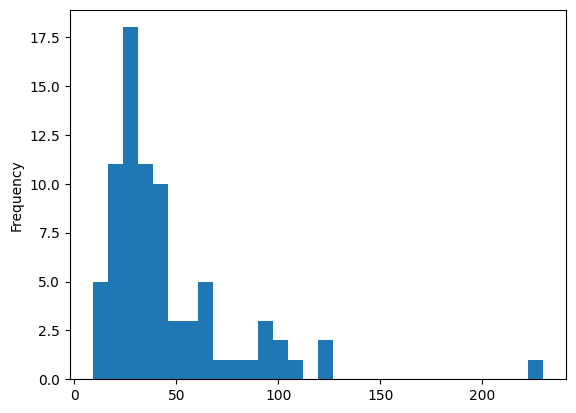

In [22]:
# plot the distribution of the number of predictions per problem
pred_count = predictions.groupby("problem_id").size()

plt.tight_layout()
pred_count.plot(kind="hist", bins=30)

In [23]:
# see how many predictions each forecaster made

forecaster_pred_count = predictions.groupby("username").size()
# print the top 10 forecasters by number of predictions
print(forecaster_pred_count.sort_values(ascending=False).head(10))

username
Mi                     78
cdob63                 78
sigis                  78
salinas                74
Jayce                  72
SE_Meyer               69
popzeus                68
caesar2084             68
MagicTheatre4MadMen    61
YuehanSimizi           51
dtype: int64


In [30]:
# we filter the predictions to only include users who made at least K predictions
K = 40

filtered_predictions = predictions[predictions["username"].isin(
    predictions.groupby("username").size().index[predictions.groupby("username").size() >= K])]

print("# of predictions: ", len(filtered_predictions))
print("# of users: ", len(filtered_predictions["username"].unique()))
print("# of problems: ", len(filtered_predictions["problem_id"].unique()))

# of predictions:  916
# of users:  15
# of problems:  78


In [49]:
def calculate_brier_score(prediction_df: pd.DataFrame, metadata_df: pd.DataFrame) -> pd.DataFrame:
    # we first use the metadata to create a mapping of problem_id to the index of the correct answer
    problem_id_to_correct_answer = dict()

    for problem_item in metadata_df.itertuples():
        correct_id = problem_item.options.index(problem_item.correct_answer)
        problem_id_to_correct_answer[problem_item.problem_id] = correct_id

    # map each prediction in prediction_df to the correct answer
    def map_fn(row):
        return (1 - row.prediction[problem_id_to_correct_answer[row.problem_id]]) ** 2

    # combine the username from prediction_df and the mapped prediction into a new dataframe
    brier_score_df = pd.DataFrame(data = {
        "username": prediction_df.username,
        "brier_score": prediction_df.apply(map_fn, axis=1)
    })

    return brier_score_df


brier_score_df = calculate_brier_score(filtered_predictions, metadata)

brier_score_df.head()

,username,brier_score
24,sigis,0.1600
28,cdob63,0.0900
33,sctlarok,0.0784
34,YuehanSimizi,0.0400
35,J-Z,0.2500


In [52]:
# rank the forecasters by averaging the brier scores in brier_score_df
averaged_brier_score_by_forecaster = brier_score_df.groupby("username").mean()
# add the number of predictions made by each forecaster
averaged_brier_score_by_forecaster["num_predictions"] = brier_score_df.groupby("username").size()
# sort by the averaged brier score
averaged_brier_score_by_forecaster.sort_values(by="brier_score", ascending=True)

,brier_score,num_predictions
username,,
smitch15,0.062535,40
YuehanSimizi,0.083461,51
sigis,0.103836,78
sctlarok,0.111066,41
salinas,0.116323,74
cdob63,0.116592,78
Jayce,0.119622,72
popzeus,0.121800,68
J-Z,0.125360,48


In [ ]:
# The above result is slightly different from the official leaderboard:
# https://www.gjopen.com/leaderboards/challenges/97-sportsball-challenge?filter=true&min_scored_questions=40
# which is not simply based on the brier score.